In [ ]:
!pip install --upgrade pip
!pip install --upgrade MDAnalysis
!pip install --upgrade MDAnalysisTests
!pip install python-igraph

In [21]:
import MDAnalysis as mda
import numpy as np
import string, time
import sys, os, re
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# import subprocess
from MDAnalysis.analysis.hbonds import HydrogenBondAnalysis as hbonds
from MDAnalysis.lib.distances import calc_bonds as MDdist3D
from MDAnalysis.lib.distances import capped_distance
import MDAnalysis.lib.mdamath as MDAmath

from pdb_class_main1 import *
import parameters as prs 
import igraph

# Main

Files needed to prepare net file is phi file and pdb file\
For calculate scores need terminalAtoms, uniqueAtoms files

In [14]:
from MDAnalysis.tests.datafiles import PDB, XTC
u = mda.Universe(PDB, XTC)

# Create dictionary of frames and their coordinates
dict_frames = {}
for ts in u.trajectory:
    atoms = u.select_atoms('all')
    coordinates = atoms.positions
    dict_frames[ts.frame] = coordinates

file1 = 'adk_oplsaa.pdb' # it's imported mda PDB file
phifile = file1.replace('.pdb', '.phi') # download phi file

# Prepare secStructure, RSA, BFactor files
prepare_secondary_structure_file(file1, phifile)
prepare_rsa_file(file1, phifile)
prepare_bfactor_file(file1, u)
cmd = "sed -i 's/SYSTEM/-/g' {}_Bfactor".format(file1.replace('.pdb', ''))
os.system(cmd)

0

In [19]:
def create_net_files(ts):
    '''
    ts - time step of mda trajectories
    for each ts we run whole processing creating net file
    '''
    file1 = f'adk_{ts}.pdb'
    u = mda.Universe(PDB, dict_frames[ts])
    u1 = u.select_atoms('protein') 

    u1_atoms = u1.atoms
    u1_resnames, u1_resids, u1_segids, u1_names = u1_atoms.resnames, u1_atoms.resids, u1_atoms.segids, u1_atoms.names

    residues = [(i+':'+str(j)+':'+k) for i, j, k in zip(u1_atoms.resnames, u1_atoms.resids, u1_segids)]
    coords = {res+':'+atom : pos for res, atom, pos in zip(residues, u1_names, u1.atoms.positions)}
    chain = {} 
    for res, atom in zip(residues, u1_names):
        if atom in ["N","O","C","CA","HA2","HA3"]:
            if res[0:3] == 'GLY' and atom in ["O","CA","HA2","HA3","N","NH"]:
                chain[res+':'+atom] = 'SC'
            else:
                chain[res+':'+atom] = 'MC'
        else:
            chain[res+':'+atom] = 'SC'

    acids_class = [AminoAcid(res) for res in u1.residues]

    
    # Writing files for PIPI,PICation, SB, Disulfide bonds
    net = open(file1.replace('.pdb', '_bonds'), 'w')
    for i in range(len(acids_class)):
        for j in range(i+1, len(acids_class)):
            bonds = find_pipi_bonds(acids_class[i], acids_class[j])
            if bonds: 
                for bond in bonds:
                    net.write(bond)
            bonds = find_pication_bonds(acids_class[i], acids_class[j])
            if bonds: 
                for bond in bonds:
                    net.write(bond)
            # saltBrdiges = []
            bonds = find_salt_bridges(acids_class[i], acids_class[j])
            if bonds: 
                for bond in bonds:
                    net.write(bond)
            bonds = find_disulfide_bonds(acids_class[i], acids_class[j])
            if bonds: 
                for bond in bonds:
                    net.write(bond)
    net.close()

    # Find hydrogen bonds
    h = hbonds(u, selection1='protein', selection2= 'protein', distance=2.5, distance_type='hydrogen', angle=120) 
    h.run()
    h.generate_table() 
    find_hydrogen_bonds(h, file1, u1_segids, coords, chain)

    # Find vanderWaals bonds
    vdw_coords = u1.atoms.positions
    pairs, distances = mda.lib.distances.capped_distance(vdw_coords, vdw_coords, max_cutoff=4.25, min_cutoff=0)
    find_vdw_bonds(pairs, file1, u1_resnames, u1_names, u1_resids, u1_segids, chain, coords)
    # this function uses for appropriate writing into file
    VandWaals_awk_replacement(file1.replace('.pdb','')+'_vdw')
    VandWaals_awk_replacement(file1.replace('.pdb','')+'_vdw2')

    # Find metal bonds
    select_metalls = 'resname {}'.format(' '.join(list(prs.metals)))
    metalls = u.select_atoms(select_metalls)
    find_metal_bonds(file1, metalls, acids_class)

    # Concatenate created files into one 
    pdb = file1.replace('.pdb', '')
    cmd = f'cat {pdb}_bonds {pdb}_hb {pdb}_vdw_noRepulse {pdb}_vdw_noRepulse2 {pdb}_metal > {pdb}_net'
    os.system(cmd) 

    # Delete unneccessary files
    cmd = f'rm {pdb}_bonds {pdb}_hb {pdb}_vdw_noRepulse {pdb}_vdw_noRepulse2 {pdb}_metal {pdb}_vdw {pdb}_vdw2'
    os.system(cmd)

In [22]:
# For each time step run the function to create total NET file
for ts in dict_frames.keys():
    create_net_files(ts)
    cmd = "sed -i 's/SYSTEM/-/g' adk_{}_net".format(ts)
    os.system(cmd)


In [23]:
# to run need terminalAtoms file
for ts in dict_frames.keys():
    cmd = "python energetics_main.py adk_oplsaa.pdb adk_{}".format(ts)
    print(cmd)
    os.system(cmd)

python energetics_main.py adk_oplsaa.pdb adk_0
python energetics_main.py adk_oplsaa.pdb adk_1
python energetics_main.py adk_oplsaa.pdb adk_2
python energetics_main.py adk_oplsaa.pdb adk_3
python energetics_main.py adk_oplsaa.pdb adk_4
python energetics_main.py adk_oplsaa.pdb adk_5
python energetics_main.py adk_oplsaa.pdb adk_6
python energetics_main.py adk_oplsaa.pdb adk_7
python energetics_main.py adk_oplsaa.pdb adk_8
python energetics_main.py adk_oplsaa.pdb adk_9


In [24]:
# need uniqueAtoms file
for ts in dict_frames.keys():
    cmd = "python centroid_main.py adk_oplsaa.pdb adk_{}".format(ts)
    print(cmd)
    os.system(cmd)

python centroid_main.py adk_oplsaa.pdb adk_0
python centroid_main.py adk_oplsaa.pdb adk_1
python centroid_main.py adk_oplsaa.pdb adk_2
python centroid_main.py adk_oplsaa.pdb adk_3
python centroid_main.py adk_oplsaa.pdb adk_4
python centroid_main.py adk_oplsaa.pdb adk_5
python centroid_main.py adk_oplsaa.pdb adk_6
python centroid_main.py adk_oplsaa.pdb adk_7
python centroid_main.py adk_oplsaa.pdb adk_8
python centroid_main.py adk_oplsaa.pdb adk_9


In [ ]:
# !zip -r /content/file.zip /content/

In [25]:
for ts in dict_frames.keys():
    cmd = "python finalscore.py adk_{}".format(ts)
    print(cmd)
    os.system(cmd)

python finalscore.py adk_0
python finalscore.py adk_1
python finalscore.py adk_2
python finalscore.py adk_3
python finalscore.py adk_4
python finalscore.py adk_5
python finalscore.py adk_6
python finalscore.py adk_7
python finalscore.py adk_8
python finalscore.py adk_9


In [26]:
import pandas as pd
df0 = pd.read_csv(f'adk_0_FinalSum', sep='\t', header=None, names=['acid', 'score0'])

for i in range(1, len(dict_frames)):
    tmp_df = pd.read_csv(f'adk_{i}_FinalSum', sep='\t', header=None, names=['acid', f'score{i}'])
    df0 = pd.merge(df0, tmp_df, on='acid')

df0.describe()

,score0,score1,score2,score3,score4,score5,score6,score7,score8,score9
count,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000
mean,0.026821,0.016852,0.004394,0.021510,0.003523,0.003860,0.012133,0.015497,0.022365,0.017022
std,1.645621,1.560929,1.668387,1.755452,1.572900,1.570449,1.702687,1.660570,1.660456,1.721977
min,-0.605502,-0.504429,-0.773817,-0.676860,-0.661740,-0.616802,-0.645861,-0.687764,-0.696986,-0.698351
25%,-0.460890,-0.504429,-0.528706,-0.513689,-0.556095,-0.616802,-0.645861,-0.543610,-0.696986,-0.494134
50%,-0.460890,-0.504429,-0.528706,-0.513689,-0.556095,-0.616802,-0.645861,-0.543610,-0.696986,-0.494134
75%,-0.139458,-0.184399,-0.254119,-0.226964,-0.278324,-0.247650,-0.104406,-0.142300,-0.083258,-0.196966
max,13.508551,13.803225,12.867660,14.171404,10.105349,9.015890,13.365360,12.350453,11.006960,13.475687


# RMSD

In [27]:
from MDAnalysis.analysis.rms import RMSD
import matplotlib.pyplot as plt
%matplotlib inline

ref = mda.Universe(PDB, dict_frames[0])
mobile = mda.Universe(PDB, XTC)

R = RMSD(mobile, reference=ref, select='backbone')
R.run()
R.rmsd

array([[0.00000000e+00, 0.00000000e+00, 6.39120343e-07],
       [1.00000000e+00, 1.00000008e+02, 8.16775382e+00],
       [2.00000000e+00, 2.00000015e+02, 6.10866973e+00],
       [3.00000000e+00, 3.00000000e+02, 7.53671026e+00],
       [4.00000000e+00, 4.00000031e+02, 7.29534342e+00],
       [5.00000000e+00, 5.00000031e+02, 1.92514503e+01],
       [6.00000000e+00, 6.00000000e+02, 1.64681023e+01],
       [7.00000000e+00, 7.00000061e+02, 1.68066847e+01],
       [8.00000000e+00, 8.00000061e+02, 1.84403093e+01],
       [9.00000000e+00, 9.00000061e+02, 2.08395717e+01]])

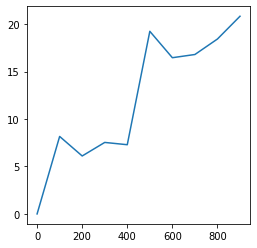

In [28]:
rmsd = R.rmsd.T[2]  
time = R.rmsd.T[1]
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.plot(time, rmsd,  label="all")

In [86]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(rmsd.reshape(-1,1))
kmeans.labels_

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1], dtype=int32)

In [32]:
# import scipy.cluster.hierarchy
# from scipy.spatial.distance import squareform

# reduced_distances = squareform(rmsd, checks=False)
# linkage = scipy.cluster.hierarchy.linkage(reduced_distances, method='average')

# plt.title('RMSD Average linkage hierarchical clustering')
# _ = scipy.cluster.hierarchy.dendrogram(linkage, no_labels=True, count_sort='descendent'

In [114]:
import MDAnalysis.analysis.encore as encore
from MDAnalysis.analysis.encore.clustering import ClusteringMethod as clm

ens2 = mda.Universe(PDB, XTC)

# https://docs.mdanalysis.org/stable/documentation_pages/analysis/encore/clustering.html
# Method
km1 = clm.KMeans(2,  # no. clusters
                 init = 'k-means++',  # default
                 algorithm="auto")

# https://docs.mdanalysis.org/1.0.0/documentation_pages/analysis/encore/confdistmatrix.html
# calculates the conformational distance (RMSD) matrix. 
# The distance matrix is calculated between all the frames of all the Universe objects given as input.
rmsd_matrix = encore.get_distance_matrix(ens2)

cluster_collection = encore.cluster(ens2, method=km1, distance_matrix=rmsd_matrix)
cluster_collection.clusters

[<Cluster with 5 elements, centroid=2, id=0>,
 <Cluster with 5 elements, centroid=7, id=1>]

In [118]:
cluster1 = cluster_collection.clusters[0]
cluster1.elements # ids of MD frames

array([0, 1, 2, 3, 4])

In [125]:
# We have centroids of clustes 2, 7
new_df = df0[['acid', 'score2', 'score7']]
new_df['sumScores'] = new_df['score2']+new_df['score7']
new_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,acid,score2,score7,sumScores
0,ALA11,-0.528706,-0.54361,-1.072316
1,ALA127,-0.528706,-0.54361,-1.072316
2,ALA17,-0.528706,-0.54361,-1.072316
3,ALA176,-0.528706,-0.54361,-1.072316
4,ALA186,-0.254119,-0.54361,-0.797729


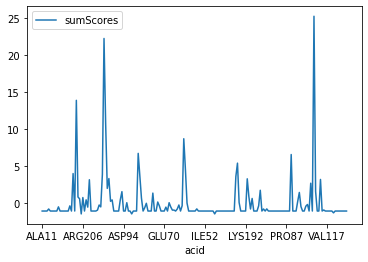

In [131]:
new_df.plot('acid', 'sumScores')